In [47]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [53]:
data_root = "ssl_dataset"
train_dirs = ["train.X1", "train.X2", "train.X3", "train.X4"]
val_dir = "val.X"
label_map_file = "Labels.json"
batch_size = 1024
image_size = 60
epochs = 10
learning_rate = 7e-3
projection_dim = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SimCLRDataset(Dataset):
    def __init__(self, root_dirs, transform):
        self.samples = []
        for rd in root_dirs:
            folder = os.path.join(data_root, rd)
            for class_folder in os.listdir(folder):
                class_path = os.path.join(folder, class_folder)
                for fname in os.listdir(class_path):
                    self.samples.append(os.path.join(class_path, fname))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        img = Image.open(path).convert('RGB')
        xi = self.transform(img)
        xj = self.transform(img)
        return xi, xj

In [4]:
contrastive_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
])

In [5]:
class SimCLR(nn.Module):
    def __init__(self, base_model='resnet18', out_dim=128):
        super(SimCLR, self).__init__()
        resnet = models.resnet18(pretrained=False)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.projector = nn.Sequential(
            nn.Linear(resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        h = self.encoder(x).squeeze()
        z = self.projector(h)
        return z

In [6]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    N = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    z = F.normalize(z, dim=1)

    similarity = torch.matmul(z, z.T)
    mask = torch.eye(2 * N, dtype=torch.bool).to(z.device)
    similarity.masked_fill_(mask, -1e9)

    sim = similarity / temperature

    targets = torch.cat([torch.arange(N) + N, torch.arange(N)], dim=0).to(z.device)
    loss = F.cross_entropy(sim, targets)
    return loss

In [7]:
def train():
    dataset = SimCLRDataset(train_dirs, contrastive_transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)

    model = SimCLR(out_dim=projection_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        print(f"Starting epoch {epoch+1}")
        for i,(xi, xj) in enumerate(loader): 
            xi, xj = xi.to(device), xj.to(device)
            zi = model(xi)
            zj = model(xj)

            loss = nt_xent_loss(zi, zj)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            print(f"Finished batch {i+1}/{len(loader)}") if (i+1)%25==0 else None

        avg_loss = total_loss / len(loader)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

    torch.save(model.encoder.state_dict(), "simclr_encoder.pth")
    print("Encoder saved.")

In [8]:
#DO NOT RUN AGAIN IF USING WEIGHTS FILEtrain()

C:\Users\Shreshth\miniconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shreshth\miniconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting epoch 1
Finished batch 25/170
Finished batch 50/170
Finished batch 75/170
Finished batch 100/170
Finished batch 125/170
Finished batch 150/170
Epoch [1/10] Loss: 6.3844
Starting epoch 2
Finished batch 25/170
Finished batch 50/170
Finished batch 75/170
Finished batch 100/170
Finished batch 125/170
Finished batch 150/170
Epoch [2/10] Loss: 6.1890
Starting epoch 3
Finished batch 25/170
Finished batch 50/170
Finished batch 75/170
Finished batch 100/170
Finished batch 125/170
Finished batch 150/170
Epoch [3/10] Loss: 6.1301
Starting epoch 4
Finished batch 25/170
Finished batch 50/170
Finished batch 75/170
Finished batch 100/170
Finished batch 125/170
Finished batch 150/170
Epoch [4/10] Loss: 6.0907
Starting epoch 5
Finished batch 25/170
Finished batch 50/170
Finished batch 75/170
Finished batch 100/170
Finished batch 125/170
Finished batch 150/170
Epoch [5/10] Loss: 6.0658
Starting epoch 6
Finished batch 25/170
Finished batch 50/170
Finished batch 75/170
Finished batch 100/170
Fini

In [54]:
def linear_probe():
    class ImageNetDataset(Dataset):
        def __init__(self, root, transform):
            self.samples = []
            self.labels = []
            with open(os.path.join(data_root,label_map_file)) as f:
                original_dict=json.load(f)
            class_names = list(original_dict.keys())
            label_to_index = {name: idx for idx, name in enumerate(class_names)}
            for class_folder in os.listdir(root):
                class_path = os.path.join(root, class_folder)
                label = label_to_index[class_folder]
                for fname in os.listdir(class_path):
                    self.samples.append(os.path.join(class_path, fname))
                    self.labels.append(label)
            self.transform = transform

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            img = Image.open(self.samples[idx]).convert('RGB')
            return self.transform(img), self.labels[idx]

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    val_dataset = ImageNetDataset(os.path.join(data_root, val_dir), transform)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    encoder = models.resnet18(pretrained=False)
    encoder = nn.Sequential(*list(encoder.children())[:-1])
    encoder.load_state_dict(torch.load("simclr_encoder.pth"))
    encoder.to(device)
    encoder.eval()

    features, labels = [], []
    with torch.no_grad():
        for i,(x,y) in enumerate(val_loader):
            x = x.to(device)
            h = encoder(x).squeeze()
            features.append(h.cpu())
            labels.extend(y)

    features = torch.cat(features)
    labels = torch.tensor(labels)

    classifier = nn.Linear(features.shape[1], 100)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    acc_list, loss_list,f1_list =[], [], []
    for epoch in range(5000):
        classifier.train()
        total_loss, correct = 0, 0
        all_preds, all_labels = [], []

        for i in range(0, len(features), 64):
            x_batch = features[i:i+64]
            y_batch = labels[i:i+64]

            preds = classifier(x_batch)
            loss = criterion(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (preds.argmax(1) == y_batch).sum().item()

            all_preds.extend(preds.argmax(1).tolist())
            all_labels.extend(y_batch.tolist())
        acc = correct / len(features)
        f1 = f1_score(all_labels, all_preds, average='macro')
    

        acc_list.append(acc)
        loss_list.append(total_loss)
        f1_list.append(f1)
        print(f"Epoch {epoch+1}: Loss={total_loss/len(val_loader):.4f}, Accuracy={acc:.4f}, F1={f1:.4f}") if (epoch+1)%50==0 else None

    plt.plot(acc_list)
    plt.xlabel('Epoch')
    plt.title("Accuracy")
    plt.savefig("SimCLR_accuracy.png")
    plt.show()
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.title("Loss")
    plt.savefig("SimCLR_loss.png")
    plt.show()

C:\Users\Shreshth\miniconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shreshth\miniconda3\envs\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 50: Loss=14.9010, Accuracy=0.0174, F1=0.0169
Epoch 100: Loss=14.1686, Accuracy=0.0374, F1=0.0364
Epoch 150: Loss=13.3901, Accuracy=0.0556, F1=0.0543
Epoch 200: Loss=12.6707, Accuracy=0.0744, F1=0.0733
Epoch 250: Loss=12.0760, Accuracy=0.0908, F1=0.0898
Epoch 300: Loss=11.5695, Accuracy=0.1100, F1=0.1082
Epoch 350: Loss=11.0505, Accuracy=0.1306, F1=0.1287
Epoch 400: Loss=10.5109, Accuracy=0.1462, F1=0.1456
Epoch 450: Loss=10.1835, Accuracy=0.1574, F1=0.1562
Epoch 500: Loss=9.8446, Accuracy=0.1670, F1=0.1654
Epoch 550: Loss=9.2674, Accuracy=0.2042, F1=0.2027
Epoch 600: Loss=9.0287, Accuracy=0.2130, F1=0.2114
Epoch 650: Loss=8.5146, Accuracy=0.2382, F1=0.2368
Epoch 700: Loss=8.1113, Accuracy=0.2648, F1=0.2637
Epoch 750: Loss=7.8860, Accuracy=0.2644, F1=0.2628
Epoch 800: Loss=7.3983, Accuracy=0.2958, F1=0.2936
Epoch 850: Loss=7.0043, Accuracy=0.3246, F1=0.3224
Epoch 900: Loss=6.6690, Accuracy=0.3452, F1=0.3429
Epoch 950: Loss=6.3321, Accuracy=0.3616, F1=0.3584
Epoch 1000: Loss=6.0743

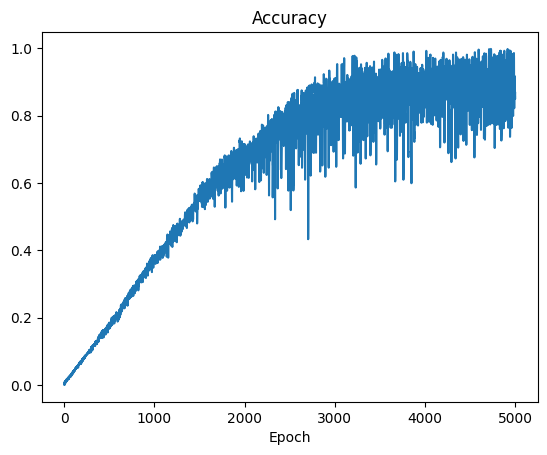

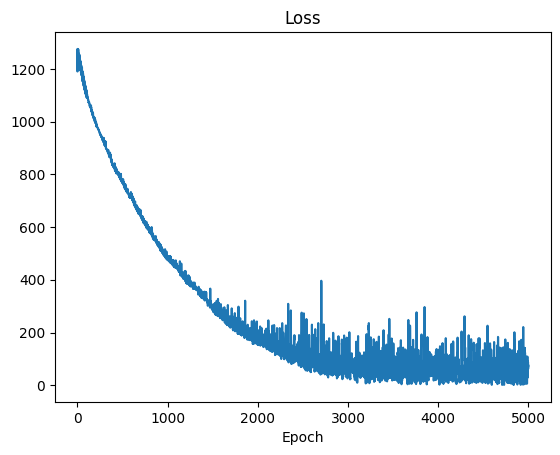

In [55]:
linear_probe()